In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [ ]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2022, 12, 31)

In [ ]:
lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]

precos = yf.download(lista_acoes, inicio, final)['Adj Close']
precos

[*********************100%%**********************]  6 of 6 completed


,EGIE3.SA,EQTL3.SA,LREN3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,
2015-01-02,14.337918,4.597055,10.465996,3.318810,12.725253,5.088044
2015-01-05,14.355506,4.421531,10.175043,3.035151,12.533893,5.122736
2015-01-06,14.645692,4.670608,10.292251,2.935870,13.036206,5.046747
2015-01-07,15.015022,4.630488,10.467375,3.074154,13.514597,4.988927
2015-01-08,15.168912,4.597055,10.479786,3.272715,13.658119,5.073176
...,...,...,...,...,...,...
2022-12-23,35.706520,26.624327,21.175209,20.212732,81.991486,37.959820
2022-12-26,35.397167,25.972786,20.042898,20.067896,82.741867,37.654175
2022-12-27,35.209686,26.032019,19.723528,20.204685,84.717575,37.476696


In [ ]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() # retorno logaritmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov()
media_retornos

EGIE3.SA    0.000456
EQTL3.SA    0.000885
LREN3.SA    0.000321
PETR4.SA    0.000897
VALE3.SA    0.000952
WEGE3.SA    0.001012
dtype: float64

In [ ]:
numero_carteiras = 100000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):

    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    tabela_pesos[k, :] = pesos

    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    tabela_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))

    tabela_sharpe[k] = tabela_retornos_esperados[k]/tabela_volatilidades_esperadas[k]

In [ ]:
indice_do_sharpe_maximo = tabela_sharpe.argmax()
tabela_pesos[indice_do_sharpe_maximo]

array([0.00074963, 0.53749635, 0.0007658 , 0.03438502, 0.07711495,
       0.34948825])

In [ ]:
["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]

['WEGE3', 'LREN3', 'VALE3', 'PETR4', 'EQTL3', 'EGIE3']

In [ ]:
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

In [ ]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(),
                                         tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste)-1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))

    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes)
limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:

    #vamos pegar a melhor volatilidade para cada retorno possível

    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
            {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})

    result = minimize(pegando_vol,peso_inicial,method='SLSQP', bounds=limites,
                      constraints=restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])


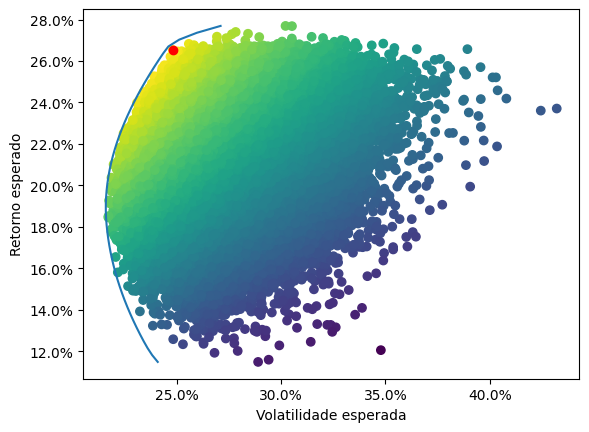

In [ ]:
fig, ax = plt.subplots()

ax.scatter(tabela_volatilidades_esperadas, tabela_retornos_esperados_arit, c = tabela_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.scatter(tabela_volatilidades_esperadas[indice_do_sharpe_maximo],
            tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.show()